In [1]:
import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import scipy.io

import scipy.sparse as sps
import matplotlib.pyplot as plt

from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

from scNCL.metrics import osr_evaluator
from scNCL.core import BuildscNCL
import scNCL.utils as utls

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(1234)

sc.settings.verbosity = 3
sc.logging.print_header()

## experiment id

In [2]:
exp_id = 'MCAOS' + '-1401'  # dataset_name + timestamp

## loading data

In [3]:
data_root = '../data/MCA/scjoint/data_os'

adata_rna = sc.read_h5ad(join(data_root, 'adata_rna_facs.h5ad')
adata_atac = sc.read_h5ad(join(data_root, 'adata_atac_cache.h5ad'))

adata_rna.obs['domain'] = 'rna'
adata_atac.obs['domain'] = 'atac'

meta_rna = adata_rna.obs.copy()
meta_atac = adata_atac.obs.copy()

meta = pd.concat([meta_rna, meta_atac], axis=0)

In [4]:
adata_rna, adata_atac

(AnnData object with n_obs × n_vars = 19726 × 15519
     obs: 'cell_type', 'domain',
 AnnData object with n_obs × n_vars = 81173 × 15519
     obs: 'Unnamed: 0', 'cell_label', 'domain', 'cell_type')

In [5]:
# low-dimension representations of raw scATAC-seq data
atac_raw_emb = np.load('../cache/MCAOS_atac_tsne.npy')
atac_raw_emb.shape

(81173, 2)

In [6]:
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':adata_atac.shape[1], 
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':False
       }  # default settings

#  outputs folder
output_dir = join(f'../outputs/{exp_id}')
os.makedirs(output_dir, exist_ok=True)

## model 

In [8]:
model = BuildscNCL(
                'non_linear', n_latent=128, bn=False, dr=0.2, 
                cont_w=0.06, cont_tau=0.4,
        )
    
model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=None, 
                pp_dict = ppd
        )
    
if 1:
    model.train(
        opt='adam', 
        batch_size=500, training_steps=800, 
        lr=0.001, lr2=0.0001, weight_decay=0,
        log_step=100, eval_atac=False, #eval_top_k=1, eval_open=True,  
    )
else:
    # loading checkpoints
    ckpt_path = join(output_dir, 'ckpt_800.pth')
    model.load_ckpt(ckpt_path)

Finding highly variable genes...
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/yanxh/gitrepo/scNCL/demo/../src/dataset.py:22: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  hvg_total = (hvg_rna) & (hvg_atac)


knn correct ratio = 0.9704
step 0, loss_cls=2.930, loss_l1_reg=0.017, center=(0.005, 0.004), corr=(0.000, 0.000), var=(2.308, 2.438), loss_cont=0.412, loss_align=0.000
step 100, loss_cls=0.155, loss_l1_reg=0.017, center=(0.105, 0.062), corr=(0.028, 0.015), var=(0.075, 0.116), loss_cont=0.387, loss_align=0.000
step 200, loss_cls=0.141, loss_l1_reg=0.016, center=(0.091, 0.060), corr=(0.024, 0.019), var=(0.083, 0.110), loss_cont=0.365, loss_align=0.000
step 300, loss_cls=0.055, loss_l1_reg=0.015, center=(0.083, 0.058), corr=(0.022, 0.021), var=(0.088, 0.109), loss_cont=0.353, loss_align=0.000
step 400, loss_cls=0.044, loss_l1_reg=0.014, center=(0.076, 0.059), corr=(0.020, 0.022), var=(0.095, 0.105), loss_cont=0.350, loss_align=0.000
step 500, loss_cls=0.033, loss_l1_reg=0.013, center=(0.070, 0.056), corr=(0.018, 0.021), var=(0.100, 0.109), loss_cont=0.343, loss_align=0.000
step 600, loss_cls=0.033, loss_l1_reg=0.012, center=(0.067, 0.055), corr=(0.017, 0.020), var=(0.104, 0.109), loss_con

In [9]:
model.eval(inplace=True)
atac_pred_type = model.annotate()

In [10]:
ad_atac = sc.AnnData(model.feat_B)
ad_atac.obs = meta_atac.copy()
ad_atac.obs['pred_type'] = atac_pred_type
ad_atac.obs['pred_conf'] = np.max(model.head_B, axis=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


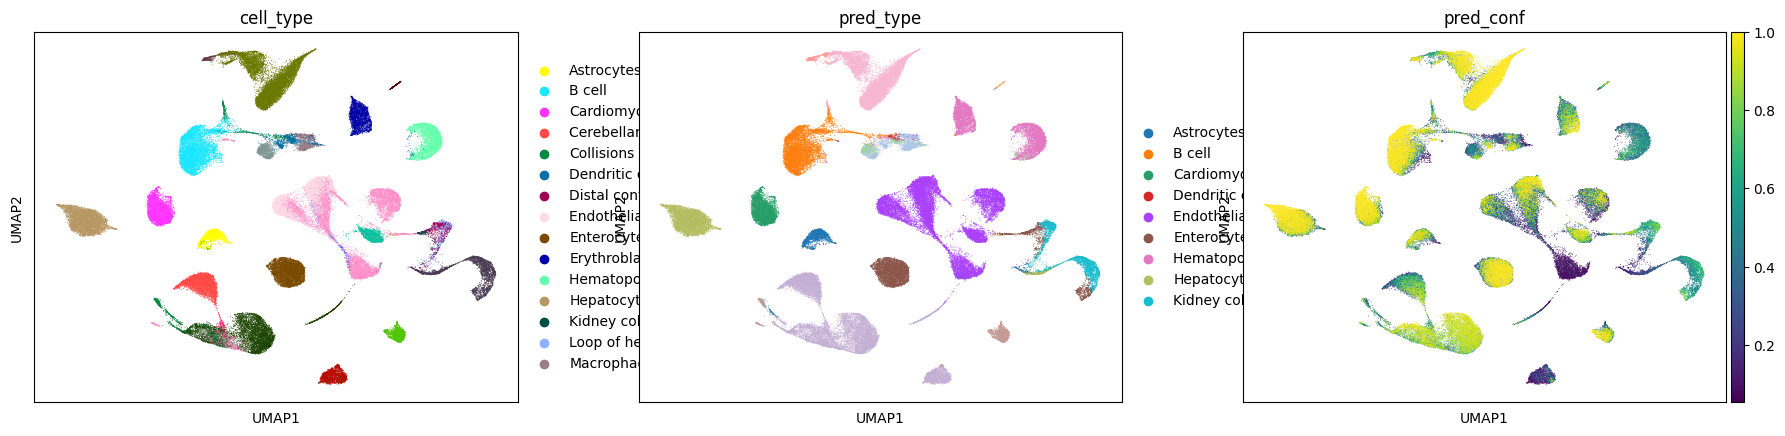

In [11]:
ad_atac = utls.umap_for_adata(ad_atac)

sc.pl.umap(ad_atac, color=['cell_type', 'pred_type', 'pred_conf'])

# Evaluation

In [12]:
share_mask = meta_atac.cell_type.isin(meta_rna.cell_type.unique()).to_numpy()
open_score = 1 - np.max(model.head_B, axis=1) # pb_max, logit_max_B

kn_data_pr = atac_pred_type[share_mask]
kn_data_gt = meta_atac.cell_type[share_mask].to_numpy()
kn_data_open_score = open_score[share_mask]

unk_data_open_score = open_score[np.logical_not(share_mask)]

closed_acc, os_auroc, os_aupr, oscr = osr_evaluator(kn_data_pr, kn_data_gt, kn_data_open_score, unk_data_open_score)

close_acc= 0.8858
AUROC= 0.7989
AUPR= 0.6237
OSCR= 0.7250
